In [28]:
import os
import sys
sys.path.insert(0, '../')
import torch
import numpy as np
import imageio
import glob
from einops import rearrange
from matplotlib import pyplot as plt

try:
    import piplite
    await piplite.install(['ipywidgets'])
except ImportError:
    pass
import ipywidgets as widgets

In [29]:
from engine.trainer import Trainer
from engine.eval import evaluation_path
from data import dataset_dict
from utils.opt import config_parser
from utils.vis import plot_palette_colors, visualize_depth_numpy, visualize_palette_components_numpy
from utils.color import rgb2hex, hex2rgb
from utils.ray import get_rays, ndc_rays_blender

## Utils

In [30]:
def print_divider():
    print()

                    
def render_one_view(test_dataset, tensorf, c2w, renderer, N_samples=-1,
                    white_bg=False, ndc_ray=False, new_palette=None, palette=None, device='cuda'):
    
    torch.cuda.empty_cache()

    near_far = test_dataset.near_far

    if palette is None and hasattr(tensorf, 'get_palette_array'):
        palette = tensorf.get_palette_array().cpu()
    
    #测试数据图像的宽高
    W, H = test_dataset.img_wh

    #旋转矩阵
    c2w = torch.FloatTensor(c2w)
    #根据方向和旋转矩阵 得到光线位置和方向
    rays_o, rays_d = get_rays(test_dataset.directions, c2w)  # both (h*w, 3)

    if ndc_ray:
        rays_o, rays_d = ndc_rays_blender(H, W, test_dataset.focal[0], 1.0, rays_o, rays_d)
    rays = torch.cat([rays_o, rays_d], 1)  # (h*w, 6)
    #render_one_view(ds_test_dataset, model, c2w, trainer.renderer, palette=torch.from_numpy(new_palette),
                                              #N_samples=-1, white_bg=white_bg, ndc_ray=ndc_ray, device=trainer.device)
    #trainer.render 等于 chunkify_render 
    res = renderer(rays, tensorf, chunk=2048, N_samples=N_samples, new_palette=new_palette,palette=palette,
                   ndc_ray=ndc_ray, white_bg=white_bg, device=device, ret_opaque_map=True)

    rgb_map = res['rgb_map']
    depth_map = res['depth_map']

    rgb_map, depth_map = rgb_map.reshape(H, W, 3).cpu(), depth_map.reshape(H, W).cpu()

    rgb_map = (rgb_map.numpy() * 255).astype('uint8')

    depth_map, _ = visualize_depth_numpy(depth_map.numpy(), near_far)

    is_vis_plt = (palette is not None) and ('opaque_map' in res)
    plt_decomp = None
    #获得调色板分解图
    if is_vis_plt:
        opaque = rearrange(res['opaque_map'], '(h w) c-> h w c', h=H, w=W).cpu()
        plt_decomp = visualize_palette_components_numpy(opaque.numpy(), palette.numpy())
        plt_decomp = (plt_decomp * 255).astype('uint8')
    
    return rgb_map, depth_map, plt_decomp


## Config

In [31]:
# Make paths accessible by this notebook
path_redirect = [
    # option name, path in the config, redirected path
    ('palette_path', './data_palette', '../data_palette')
]

In [32]:
run_dir = '../logs/fern/'
ckpt_path = None
out_dir = os.path.join(run_dir, 'demo_out')

print('Run dir:', run_dir)
print('Demo output dir:', out_dir)

Run dir: ../logs/fern/
Demo output dir: ../logs/fern/demo_out


## Load and Setup

In [33]:
# Read args
parser = config_parser()
#对args.txt里的参数进行获取
config_path = os.path.join(run_dir, 'args.txt')
if os.path.exists(config_path):
    with open(config_path, 'r') as f:
        args, remainings = parser.parse_known_args(args=[], config_file_contents=f.read())
        
        # override ckpt path
        if ckpt_path is not None:
            setattr(args, 'ckpt', ckpt_path)
        
        # redirect path
        for entry in path_redirect:
            setattr(args, entry[0], getattr(args, entry[0]).replace(entry[1], entry[2]))

        print('Args loaded:', args)
else:
    print(f'ERROR: cannot read args in {run_dir}.')
print_divider()


# Setup trainer
print('Initializing trainer and model...')
ckpt_dir = os.path.join(run_dir, 'checkpoints')
tb_dir = os.path.join(run_dir, 'tensorboard')
#训练器
trainer = Trainer(args, run_dir, ckpt_dir, tb_dir)
#模型
model = trainer.build_network()
model.eval()
print_divider()


# Create downsampled dataset
dataset = dataset_dict[args.dataset_name]
ds_test_dataset = dataset(args.datadir, split='test', downsample=args.downsample_train * 2., is_stack=True)
print('Downsampled dataset loaded')


Args loaded: Namespace(L1_weight_inital=0.0, L1_weight_rest=0.0, N_vis=-1, N_voxel_final=262144000, N_voxel_init=2097156, Ortho_weight=0.0, Plt_bd_weight=1.0, Plt_opaque_conv_weight=0.0, Plt_opaque_sps_weight=0.001, TV_weight_app=1.0, TV_weight_density=1.0, alpha_mask_thre=0.0001, basedir='./logs', batch_size=4096, ckpt=None, config='configs/fern.txt', data_dim_color=27, datadir='/home/ubuntu/Rencq/nerf_data/nerf_llff_data/fern', dataset_name='llff', density_shift=-10.0, distance_scale=25.0, downsample_test=1.0, downsample_train=4.0, expname='fern', export_mesh=0, fea2denseAct='relu', fea_pe=0, featureC=128, learn_palette=True, lindisp=False, lr_basis=0.001, lr_decay_iters=-1, lr_decay_target_ratio=0.1, lr_init=0.02, lr_upsample_reset=1, model_name='PaletteTensorVM', nSamples=1000000, n_iters=25000, n_lamb_sh=[48, 12, 12], n_lamb_sigma=[16, 4, 4], ndc_ray=1, no_reload=0, palette_init='userinput', palette_path='../data_palette/fern/rgb_palette.npy', perturb=1.0, pos_pe=6, progress_refre

## Palette Editing

In [34]:
palette_prior = trainer.palette_prior.detach().cpu().numpy()
palette = model.renderModule.palette.get_palette_array().detach().cpu().numpy()

Initial palette prior:


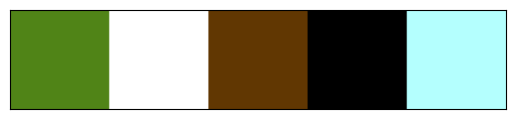

[[0.41602486 0.63563836 0.3440979 ]
 [0.9707253  1.0001445  1.0011418 ]
 [0.3282698  0.14973429 0.08722832]
 [0.00333977 0.03597294 0.04261845]
 [1.0010816  0.7884385  0.5119632 ]]


In [35]:
print('Initial palette prior:')
plot_palette_colors(palette_prior)
print(palette)

Optimized palette:
[[0.5        0.63563836 0.5       ]
 [0.7        0.7        0.7       ]
 [0.5        0.5        0.5       ]
 [0.5        0.5        0.5       ]
 [0.7        0.7        0.5119632 ]]


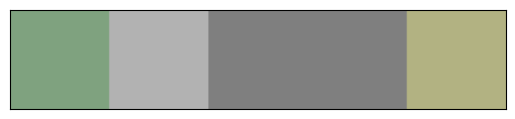

In [20]:
print('Optimized palette:')
new_palette = palette.clip(0., 1.)
# palette[1] = palette[1].clip(0.5,1.)
new_palette = new_palette.clip(0.5,0.7)
print(new_palette)
plot_palette_colors(new_palette)

In [21]:
color_pickers = []

for i in range(palette.shape[0]):
    color_picker = widgets.ColorPicker(concise=False, description=f'Color {i}', value=rgb2hex(new_palette[i]), disabled=False)
    color_pickers.append(color_picker)

box_layout = widgets.Layout(width='100%', grid_template_rows='auto', grid_template_columns='25% 25% 25% 25%')
box_auto = widgets.GridBox(children=color_pickers, layout=box_layout)
display(box_auto)

GridBox(children=(ColorPicker(value='#80a280', description='Color 0'), ColorPicker(value='#b2b2b2', descriptio…

Palette for rendering:


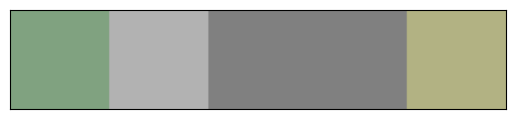

In [22]:
print('Palette for rendering:')

new_palette = np.array([hex2rgb(cl_pk.value) for cl_pk in color_pickers]).astype(np.float32) / 255.
plot_palette_colors(new_palette)

## Rendering

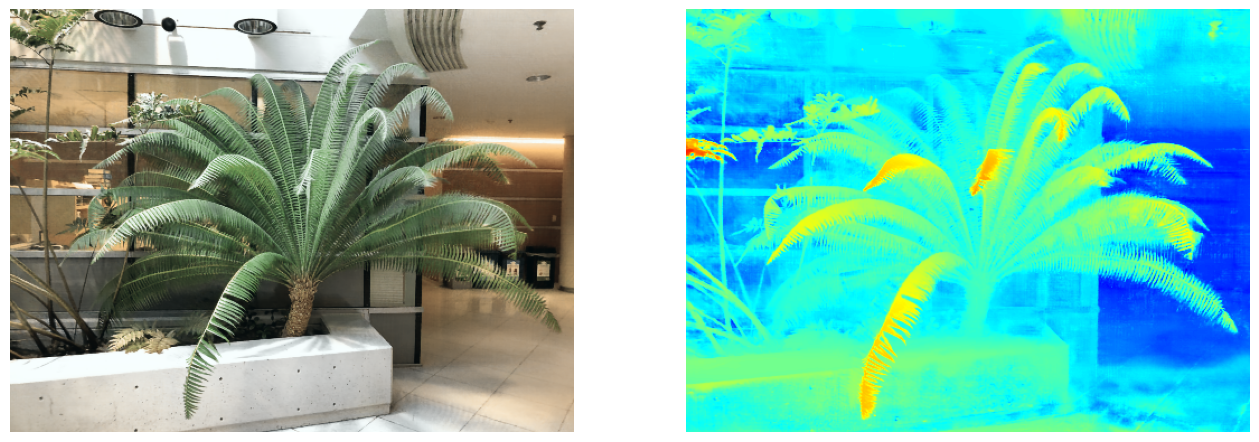

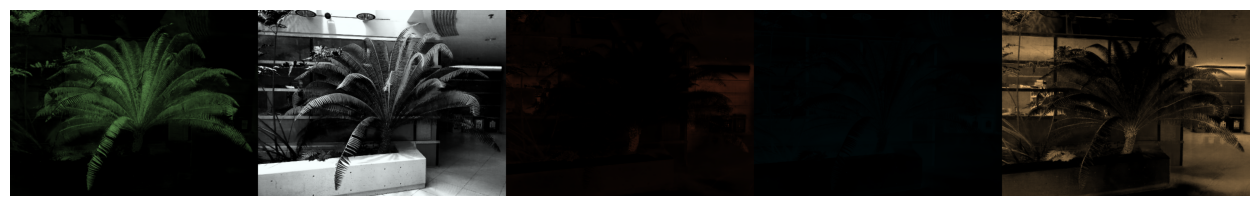

In [23]:
# Modify this to change the rendering view
render_cam_idx = 1

c2w = ds_test_dataset.poses[render_cam_idx]
white_bg = ds_test_dataset.white_bg
ndc_ray = args.ndc_ray

with torch.no_grad():
    
    rgb, depth, plt_decomps = render_one_view(ds_test_dataset, model, c2w, trainer.renderer, palette=torch.from_numpy(palette),new_palette=torch.from_numpy(new_palette),
                                              N_samples=-1, white_bg=white_bg, ndc_ray=ndc_ray, device=trainer.device)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))
axes[0].set_axis_off()
axes[0].imshow(rgb)
axes[1].set_axis_off()
axes[1].imshow(depth)

fig, axes = plt.subplots(1, 1, figsize=(16, 8))
axes.set_axis_off()
axes.imshow(plt_decomps)


In [24]:
from utils.color_decomposition import color_decomposition
w, h = ds_test_dataset.img_wh
def plot_color_decomposition(rgbs,palette_rgb,plot_palette_color_idx=0,dataset=None,fg=None):
    # palette_rgb = palette_rgb.clip(0.,1.)
    rgbs = torch.tensor(rgbs/255)
    rgbs = torch.reshape(rgbs,(-1,3))
    palette_rgb = torch.tensor(palette_rgb)
    palette_number = palette_rgb.shape[0]
    color_deco = color_decomposition(rgbs,palette_rgb) # bs * h * w
    # print(rgbs)
    print(palette_rgb)
    plot_palette_color =  0
    true_idx = (color_deco != plot_palette_color) # bs * 1
    
    if dataset is not None and dataset.white_bg and fg is not None:
        all_rgb_cp = dataset.all_rgbs.clone().cpu()
        all_rgb_cp_original = dataset.all_rgbs.clone().cpu()
        fg[fg==True] = true_idx
    
        all_rgb_cp[fg] = 1.
    else:
        all_rgb_cp = torch.clone(rgbs)
        all_rgb_cp_original = torch.clone(rgbs)
        all_rgb_cp[true_idx] = 1.


    
    all_rgb_maps = torch.reshape(all_rgb_cp,(-1, h, w, 3))
    # print(all_rgb_maps)
    all_rgb_cp_original = torch.reshape(all_rgb_cp_original,(-1,h,w,3))
    
    
    
    
    fig,axes = plt.subplots(1,2)
    axes[0].imshow(all_rgb_maps[plot_palette_color_idx].clone().numpy())
    axes[1].imshow(all_rgb_cp_original[plot_palette_color_idx].clone().numpy())

tensor([[0.4160, 0.6356, 0.3441],
        [0.9707, 1.0001, 1.0011],
        [0.3283, 0.1497, 0.0872],
        [0.0033, 0.0360, 0.0426],
        [1.0011, 0.7884, 0.5120]])


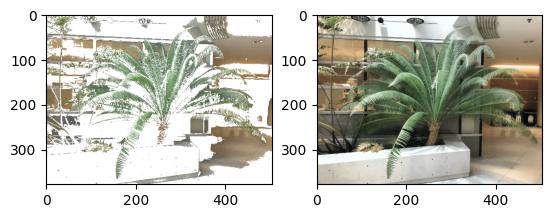

In [25]:
plot_color_decomposition(rgb,palette,dataset=None)

In [26]:
# Run the cells below to save this editing

'''Modify this to name this editing'''
edit_name = 'red_chair'

assert edit_name

out_fn = f'rgb_palette{"_" + edit_name if edit_name else ""}'
out_path = os.path.join(out_dir, f'{out_fn}.npy')

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

if os.path.exists(out_path):
    print('Error: file exists. Please specify another `edit_name`.')
else:
    np.save(out_path, new_palette)
    print('Save palette to', out_path)


Save palette to ../logs/fern/demo_out/rgb_palette_red_chair.npy


In [27]:
'''Choose between 'test' / 'path' '''
cam_poses='test'

save_dir = os.path.join(out_dir, f'render_{cam_poses}{"_" + edit_name if edit_name else ""}')

if os.path.exists(save_dir):
    print('Error: directory exists. Please specify another `edit_name`.')
else:
    c2ws = trainer.test_dataset.poses if cam_poses == 'test' else trainer.test_dataset.render_path
    if cam_poses == 'test' and args.dataset_name == 'llff':
        c2ws = c2ws[::8, ...]
    white_bg = trainer.test_dataset.white_bg
    ndc_ray = trainer.args.ndc_ray

    print('Save renderings to', save_dir)
    print('=== render path ======>', c2ws.shape)
    with torch.no_grad():
        evaluation_path(trainer.test_dataset, model, c2ws, trainer.renderer, save_dir, palette=torch.from_numpy(palette),new_palette=torch.from_numpy(new_palette),
                        N_samples=-1, white_bg=white_bg, ndc_ray=ndc_ray, save_video=True, device=trainer.device)

Save renderings to ../logs/fern/demo_out/render_test_red_chair
=== render path ======> (3, 3, 4)


  0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 